In [36]:
---
title: Classifying Palmer Penguins
author: Caitlin Baxter
date: '2023-02-23'
image: "adelie.jpg"
description: "Classifying Adelie, Gentoo, and Chinstrap Penguins."
format: html
---

SyntaxError: invalid syntax (1265329890.py, line 1)

### Classifying Palmer Penguins

In [ ]:
# Load Data

import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

### Abstract
In this blog post I investigated the classification of Gentoo, Adelie, and Chinstrap penguins. It was determined that using Logistic Regression with the variables culmen length, culmen depth, and the island where the penguins are found allowed for the correct classification of penguin 100.0% of the time on the test data. The culmen is the dorsal ridge atop the bill of the penguin, and its depth and length varies between the three species. 

![](adelie.jpg)

Figure 1: Adelie penguins

image source: https://i.natgeofe.com/n/00c35612-9827-40d9-a04e-6079806dca52/3798855_2x1.jpg

![](Chinstrap-penguin.jpg)

Figure 2: Chinstrap penguin

image source: https://live.staticflickr.com/707/31973598931_6d9bfd3f18_b.jpg

![](gentoo.jpg)

Figure 3: Gentoo penguin

image source: https://cdn.britannica.com/08/152708-050-23B255B3/Chinstrap-penguin.jpg

Logistic regression was compared with Decision Tree Classification and Support Vector Classification and was determined to be the most accurate model when the C value was set to 17.

In [ ]:
# Data Preparation

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

summary_table = train.groupby(["Species", "Island"])["Body Mass (g)"].mean()
print(summary_table)


Species                                    Island   
Adelie Penguin (Pygoscelis adeliae)        Biscoe       3711.363636
                                           Dream        3728.888889
                                           Torgersen    3712.804878
Chinstrap penguin (Pygoscelis antarctica)  Dream        3743.421053
Gentoo penguin (Pygoscelis papua)          Biscoe       5039.948454
Name: Body Mass (g), dtype: float64


From this summary table it is evident that Chinstrap penguins only live on the Dream island while Gentoo penguins only live on Biscoe. Meanwhile, Adelie Penguins live on Biscoe, Dream, adn Torgersen. This suggests that the Island where an individual is located may be a good variable for a machine learning algorithm as we know that if an individual is located on torgersen they must be an Adelie and that if an individual is found on Dream it is not a Gentoo penguin.  

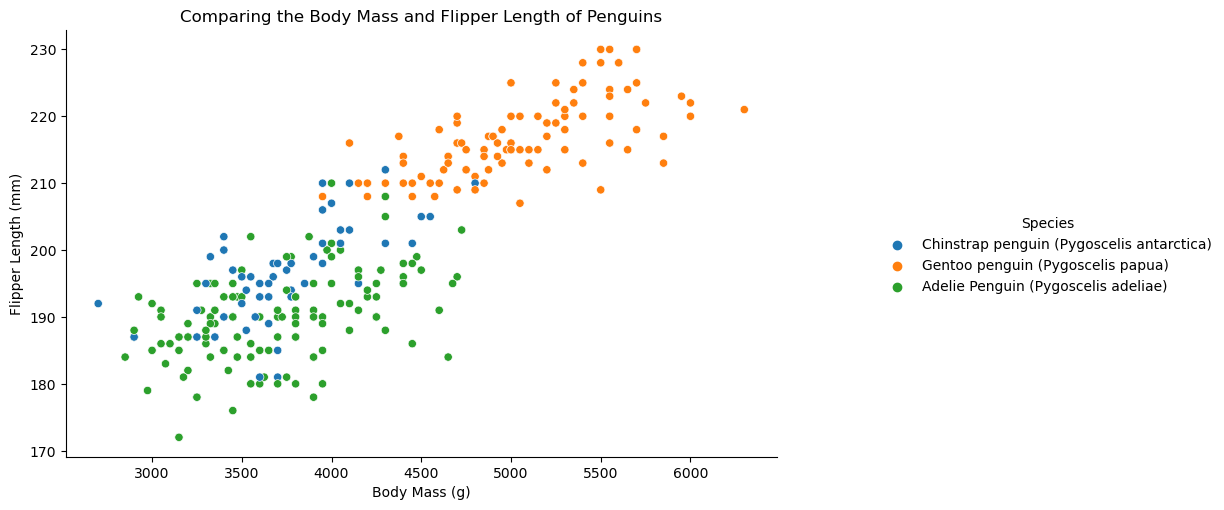

In [ ]:
mass_table = sns.relplot(data = train, x = "Body Mass (g)" , y = "Flipper Length (mm)", hue = "Species")
mass_table.set_axis_labels("Body Mass (g)", "Flipper Length (mm)")
mass_table.add_legend(frameon=True)
mass_table.legend.set_bbox_to_anchor((1.5, .6))
plt.gca().set(title = "Comparing the Body Mass and Flipper Length of Penguins")
print(mass_table)

From this figure it is apparent that the flipper length of a penguin is positively related with their body mass. It is clear that Gentoo penguins are generally larger than chinstrap and adelie penguins, and the latter two are relatively similar in size.

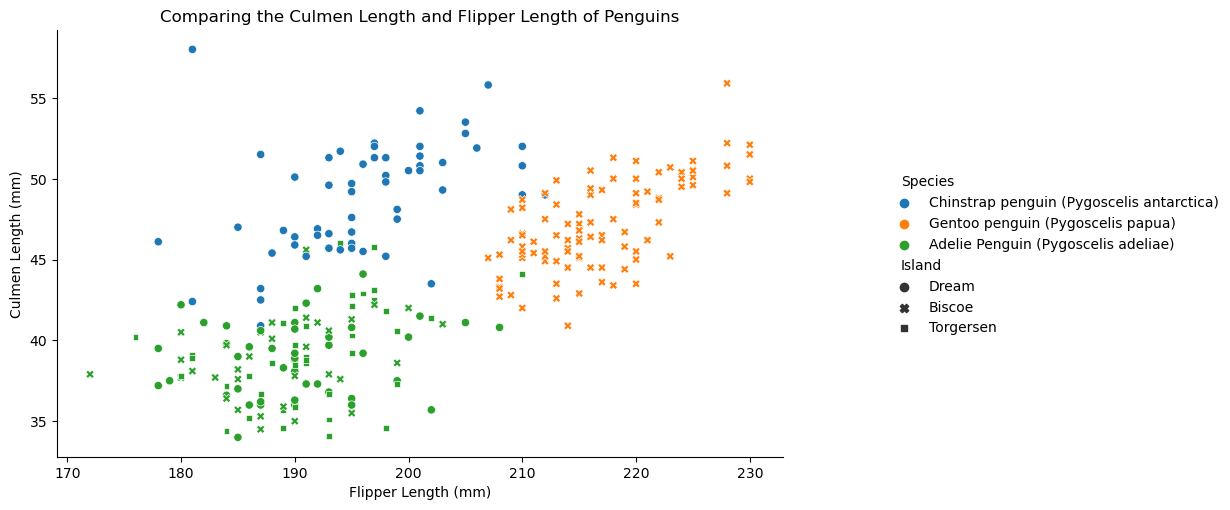

In [ ]:
flipper_table = sns.relplot(data = train, x = "Flipper Length (mm)" , y = "Culmen Length (mm)", hue = "Species", style = "Island")
flipper_table.set_axis_labels("Flipper Length (mm)", "Culmen Length (mm)")
flipper_table.add_legend(frameon=True)
plt.gca().set(title = "Comparing the Culmen Length and Flipper Length of Penguins")
flipper_table.legend.set_bbox_to_anchor((1.5, .6))
print(flipper_table)

In this plot we can see that while Adelie and Chinstrap penguins have similar Flipper lengths, Chinstrap penguins generally have longer culmens. The flipper and culmen length of Adelie penguins does not appear to vary greatly depending on the island on which they were found. 

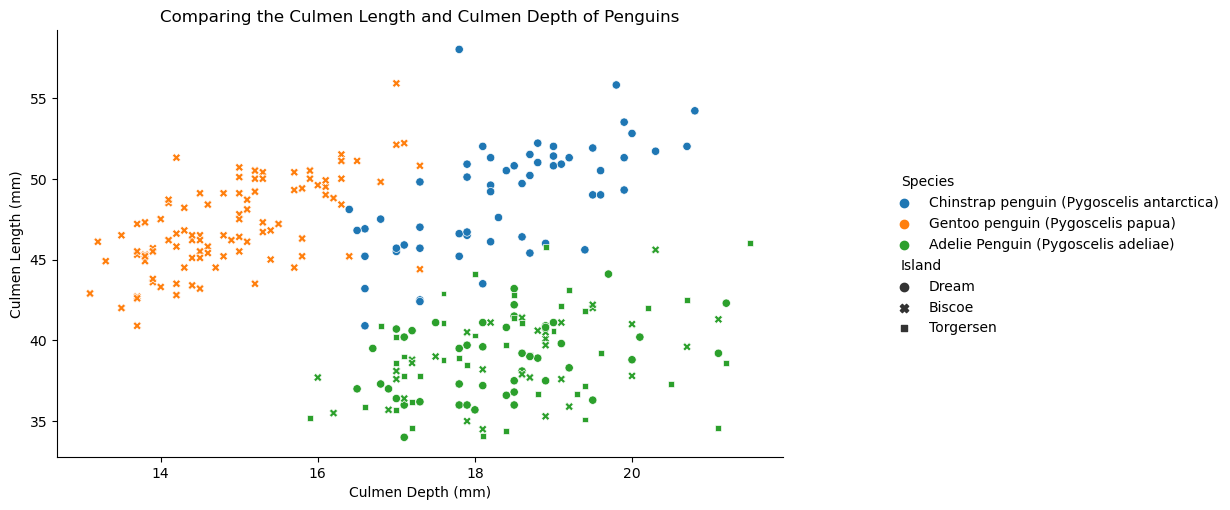

In [ ]:
culmen_table = sns.relplot(data = train, x = "Culmen Depth (mm)" , y = "Culmen Length (mm)", hue = "Species", style = "Island")
culmen_table.set_axis_labels("Culmen Depth (mm)", "Culmen Length (mm)")
culmen_table.add_legend(frameon=True)
plt.gca().set(title = "Comparing the Culmen Length and Culmen Depth of Penguins")
culmen_table.legend.set_bbox_to_anchor((1.5, .6))
print(culmen_table)

In this plot, we observe that the culmen length and culmen depth seem to be generally distinct between species. Through this preliminary analysis, I decided to focus my search on looking at the combination of qualitative variables with the quantitative variables that relate to the size of the penguins, as they appear to vary in body mass, flipper length, and the size of their culmens.

In [37]:
from itertools import combinations
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import preprocessing

# these are not actually all the columns: you'll 
# need to add any of the other ones you want to search for
all_qual_cols = ["Clutch Completion", "Sex", "Island"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']

def logisticRegression(X_train, y_train):
  best_score = 0
  best_c = 0
  for c in range(1, 20): 
    LR = LogisticRegression(max_iter = 5000, C = float(c))
    LR.fit(X_train, y_train)
    cv_scores_LR = cross_val_score(LR, X_train, y_train, cv = 5)
    if cv_scores_LR.mean() > best_score:
      best_score = cv_scores_LR.mean()
      best_c = c
  return cv_scores_LR.mean(), best_c

def decisionTree(X_train, y_train):
  best_score = 0
  best_max_depth = 0
  for i in range(1, 100):
    DT = DecisionTreeClassifier(max_depth = i)
    DT.fit(X_train, y_train)
    cv_scores_DT = cross_val_score(DT, X_train, y_train, cv = 5)
    if cv_scores_DT.mean() > best_score:
      best_score = cv_scores_DT.mean()
      best_max_depth = i
  return best_score, best_max_depth

def svc(X_train, y_train):
  xscaler = preprocessing.StandardScaler().fit(X_train)
  X_scaled = xscaler.transform(X_train)
  gammas = 10**np.arange(-5, 5)
  best_score = 0
  best_gamma = gammas[0]
  for gamma in gammas:
    svc = SVC(gamma = gamma)
    svc.fit(X_scaled, y_train)
    cv_scores_svc = cross_val_score(svc, X_scaled, y_train, cv = 5)
    if cv_scores_svc.mean() > best_score:
      best_score = cv_scores_svc.mean()
      best_gamma = gamma
  return best_score, best_gamma

best_vars = []
max_score = 0
modelType = ""

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    select_X_train = X_train[cols]
    
    # -- Logistic Regression --
    LR_score, c = logisticRegression(select_X_train, y_train)
    if LR_score > max_score:
      max_score = LR_score
      best_vars = cols
      modelType = "LR"
      print(max_score, best_vars, modelType, c)

    # -- Decision Tree -- 
    DT_score, max_depth = decisionTree(select_X_train, y_train)
    if DT_score > max_score:
      max_score = DT_score
      best_vars = cols
      modelType = "DT"
      print(max_score, best_vars, modelType, max_depth)
   
    # -- SVC --
    svc_score, gamma = decisionTree(select_X_train, y_train)
    if svc_score > max_score:
      max_score = svc_score
      best_vars = cols
      modelType = "svc"
      print(max_score, best_vars, modelType, gamma)

print(best_vars, max_score, modelType) 



0.9530920060331824 ['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Culmen Depth (mm)'] LR 1
0.9883107088989442 ['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)'] LR 1
0.9883861236802414 ['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Body Mass (g)'] LR 18
1.0 ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)'] LR 17
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)'] 1.0 LR


Similar to my observations during my initial investigation into the different variables, we see that Island, Culment Length, and Culmen Depth were used in the most accurate model. The Linear Regression model outperformed both the SVC and the Decision Tree. It was determined that when C = 17, the model was 100% accurate. The C is the inverse regularization strength, and the smaller the value specifies stronger regularization (sklearn documentation). C being 17 indicates a weaker regularization and suggests that the model may be focusing on minimizing error in the training data and may not regularize as well. I decided to test the model again with more cross validation. 

In [ ]:
X_select = X_train[['Culmen Depth (mm)', 'Culmen Length (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']]
LR = LogisticRegression(max_iter = 5000, C = 1.0)
LR.fit(X_select, y_train)
default_c_cv_scores_LR = cross_val_score(LR, X_select, y_train, cv = 5)
default_c_cv_scores_LR.mean()

LR = LogisticRegression(max_iter = 5000, C = 17.0)
LR.fit(X_select, y_train)
cv_scores_LR = cross_val_score(LR, X_select, y_train, cv = 5)
cv_scores_LR.mean()

print(default_c_cv_scores_LR.mean())
print(cv_scores_LR.mean())

0.9843891402714933
1.0


When I re-ran the Logistic Regression Model with cross validation with the default value of C vs the one that was found to be most effecient in the above function, it is clear that the Logistic Regression model is already fairly accurate at classifying types of penguins using Culmen Depth, Culmen Length, and the Island that they are found.So I decided to test the LR model on the test data. 

In [ ]:
# Testing the Model on Test Data

test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
cols = ['Culmen Depth (mm)', 'Culmen Length (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']

X_test, y_test = prepare_data(test)

X_select = X_train[['Culmen Depth (mm)', 'Culmen Length (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']]
LR = LogisticRegression(max_iter = 5000, C = 1.0)
LR.fit(X_select, y_train)

y_preds = LR.predict(X_test[cols])
LR.score(X_test[cols], y_test)


1.0

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_preds, normalize = "true")

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

As shown in the above confusion matrix the model accurately predicted the species of penguin each time when looking at the Island, the Culmen Length, and Culmen Depth.

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

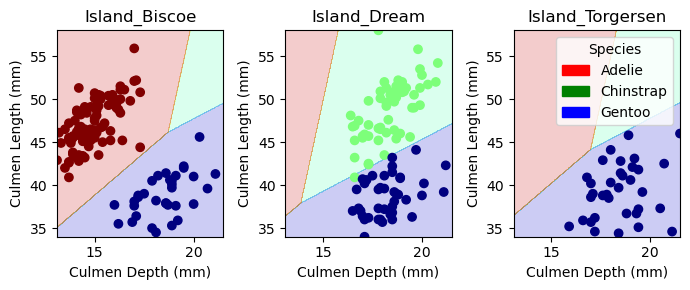

In [18]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

plot_regions(LR, X_train[cols], y_train)


### Discussion
It was determined that when classifying Chinstrap, Gentoo, and Adelie penguins, looking at the length and depth of their culmen along with the island where they are found. The model was able to correctly classify the type of penguin 100% of the time. Through a preliminary investigation of the data, it was evident that Island would likely be a helpful variable in determining the species of the penguins. This was supported when Island was selected as one of the variables in the three variable combination for the best accuracy in the for loop. In the confusion matrix, it is evident that all three types of penguins were correctly identified in the test dataset. 

In this blog post I learned the importance of investigating different values of parameters and how they affect the model. When I was looping through the different variables, I had the script print out the combinations of variables, their accuracy, and the type of model so I could see how it ultimately found the best one. It was interesting to see how changing the value of C in Logisitic Regression could change the model's ability to accurately classify. For example moving C = 16 to C = 17, boosted the accuracy from 99.2% to 100.0%